In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [11]:
from google.cloud import bigquery

client = bigquery.Client(project='bads-7105-308315')

df = client.query('''
SELECT * FROM `bads-7105-308315.supermarket.transaction`
WHERE CUST_CODE IS NOT NULL 
''').to_dataframe()

df

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,20071005,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02
1,200733,20071010,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02
2,200741,20071209,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000472158,MM,YF,994108700468327,L,MM,Full Shop,Grocery,STORE00001,LS,E02
3,200731,20070929,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000099658,LA,OF,994107700237811,L,LA,Full Shop,Mixed,STORE00001,LS,E02
4,200746,20080108,3,15,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000556927,MM,None,994109200504187,L,MM,Top Up,Fresh,STORE00001,LS,E02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802887,200633,20061009,2,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000689580,LA,OT,994102700591584,L,LA,Full Shop,Mixed,STORE00002,LS,W01
802888,200634,20061022,1,16,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000910590,LA,OA,994102800730797,L,LA,Top Up,Grocery,STORE00002,LS,W01
802889,200618,20060701,7,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000956717,LA,OA,994101200777910,L,LA,Top Up,Fresh,STORE00002,LS,W01
802890,200617,20060622,5,18,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000544241,LA,YA,994101100506174,L,LA,Top Up,Fresh,STORE00002,LS,W01


In [17]:
import pandas as pd
import datetime as dt

In [25]:
campaign_date = dt.datetime(2021,3,17)
df_transactions = df.copy()
df_transactions['SHOP_DATE'] = pd.to_datetime(df_transactions['SHOP_DATE'], format='%Y%m%d')
df_transactions['AGE'] = (campaign_date - df_transactions['SHOP_DATE']).dt.days
df_transactions = df_transactions.sort_values(['CUST_CODE','SHOP_DATE'])
df_transactions.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION,AGE
188786,200645,2007-01-06,7,13,1,2.44,PRD0901946,CL00079,DEP00022,G00007,D00002,CUST0000000181,MM,None,994103900142002,S,MM,Small Shop,Fresh,STORE00001,LS,E02,5184
578804,200607,2006-04-16,1,18,1,0.40,PRD0901383,CL00044,DEP00011,G00004,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
674063,200607,2006-04-16,1,18,1,0.72,PRD0903052,CL00031,DEP00008,G00004,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
743565,200607,2006-04-16,1,18,1,2.86,PRD0903953,CL00076,DEP00022,G00007,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
770706,200607,2006-04-16,1,18,1,1.79,PRD0904393,CL00087,DEP00025,G00008,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449


# **Create Features**

In [ ]:
#Customer Movement
df_movement =  df_transactions[['customer_id','trans_date']]
df_movement['date_lag'] = df_movement.groupby(['customer_id'])['trans_date'].shift(1)
df_movement['date_lead'] = df_movement.groupby(['customer_id'])['trans_date'].shift(-1)
df_movement['date_diff'] = (df_movement['trans_date'] - df_movement['date_lag']).dt.days

In [27]:
df_sgv1 = df_transactions.groupby('CUST_CODE').agg(
        recency=('AGE', min),                       
        frequency=('CUST_CODE', len),                  
        monetary=('SPEND', sum), 
        ticket_size=('SPEND','mean'),
        std_ticket_size=('SPEND','std'),        
        length_of_stay=('AGE', lambda x: x.max() - x.min()),
     )
df_sgv1.head()

,recency,frequency,monetary,ticket_size,std_ticket_size,length_of_stay
CUST_CODE,,,,,,
CUST0000000181,5184,1,2.44,2.440000,NaN,0
CUST0000000369,4638,699,959.33,1.372432,1.790510,811
CUST0000000689,4650,185,328.57,1.776054,1.797741,337
CUST0000000998,5367,4,5.95,1.487500,0.695000,64
CUST0000001163,4651,25,39.74,1.589600,1.870184,609


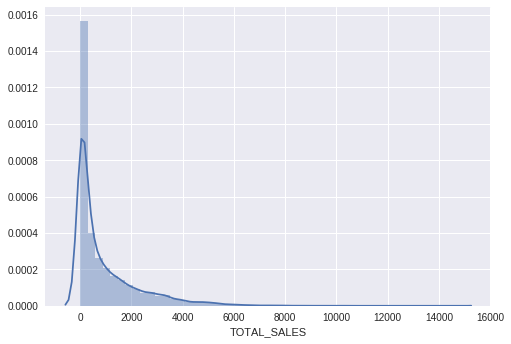

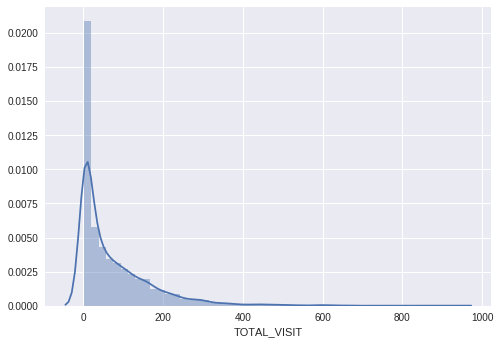

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, col in enumerate(df.columns[1:]):
    plt.figure(i)
    sns.distplot(df[col])
    
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

df_std = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[1:]]))
df_std.head(5)

,0,1
0,0.728891,1.750567
1,0.222925,1.750567
2,0.726733,1.750567
3,2.735129,4.269142
4,2.310008,4.269142


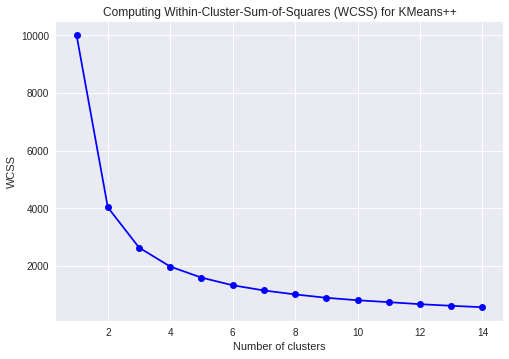

In [ ]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_std)
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS) for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
#let's choose k = 7
cluster = KMeans(n_clusters=7)
df['cluster'] = cluster.fit_predict(df_std)

In [ ]:
dfCluster = df.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster

,cluster,TOTAL_SALES,TOTAL_VISIT,NO_CUST
0,0,138.411809,14.078606,2697
1,1,1400.729032,172.572632,475
2,2,981.317955,79.483776,1017
3,3,2647.487282,322.333333,195
4,4,5432.253543,222.417323,127
5,5,4927.428571,564.873016,63
6,6,3008.894883,147.544601,426


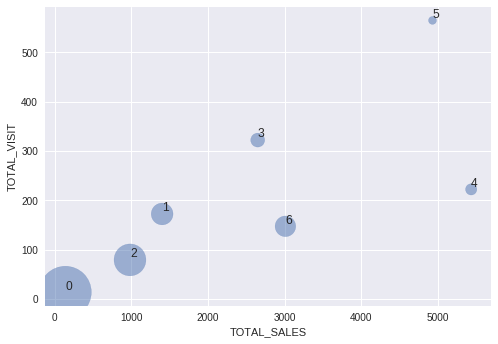

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_SALES'][i], dfCluster["TOTAL_VISIT"][i]), horizontalalignment='middle', verticalalignment='middle')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


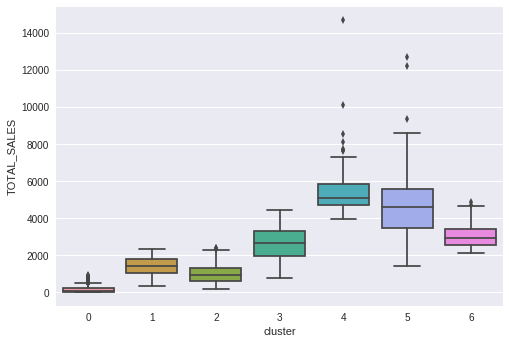

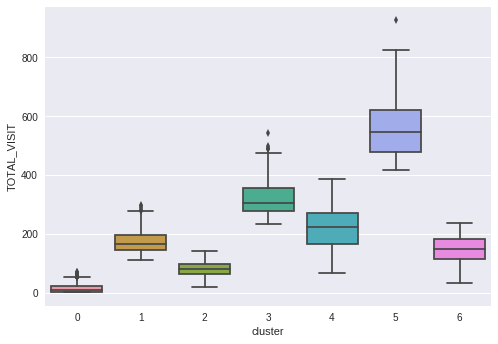

In [ ]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

predictors = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TOTAL_SALES          Importance: 0.55
Variable: TOTAL_VISIT          Importance: 0.45
